In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from Utils.IOUtils import *
from Backtesting.Vectorized.Strategy import MovingAverageStrategy, SLMStrategy
from Backtesting.Vectorized.backend import vectorized_backtest
from Backtesting.Vectorized.cross_compare import ensembler
# ====== Initial Configuration ========
DATA_DIR = "./"
ASSET = "Ag"
OUTPUT_DIR = "./Output"
# =====================================

ASSET_PATH = Path('./',OUTPUT_DIR, ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

# SLM model: Single-Order

### Import data and the probability table

In [2]:
data = pd.read_csv(DATA_DIR + 'ag_1712_5min.csv')
slm = pd.read_csv(DATA_DIR + 'ag_5min_freq.csv')[['prior', 'max']]
slm = slm.rename(columns={'max': 'signal'})

### Generate signals

In [3]:
signals = SLMStrategy(data, slm,2).generatingsignal()
signals['match'] = signals.apply(lambda row: 1 if row['signal'] == row['Direction'] else 0, axis=1)
signals.to_csv(str(ASSET_PATH/'ag_5min_signal.csv'), index=False)

### Run backtest

In [4]:
#tca: trading cost to be applied
test = vectorized_backtest(signals, tca = 'None')
returns = test.runtest()
test.cal_performance()
test.performance

{'Annualized Volatility': 0.11280587736749559,
 'Average Daily Return': 0.004229505571314624,
 'Average Negative Return': -0.0011132006319265072,
 'Average Positive Return': 0.0013145274650836198,
 'Average Return per Trade': 0.00019606979469670446,
 'Largest Losing Trade': -0.0057831486480913455,
 'Largest Winning Trade': 0.017552864117196344,
 'Max Drawdown': -0.008142270450427369,
 'Profit Factor': 1.1808540413857798,
 'Sharpe Ratio': 9.373415796270676,
 'Total Number of Trades': 302,
 'Total Return': 1.0592130779984048,
 'Winning Rate': 0.2781456953642384}

# SLM Model: Multiple Order Comparison

### Generate signals with different orders

In [16]:
def compile_signal(DATA_PATH, max_order=6):
    data = pd.read_csv(DATA_PATH + 'ag_1712_5min.csv')
    slm = pd.read_csv(DATA_PATH + 'ag_5min_freq.csv')[['prior', 'max']]
    slm = slm.rename(columns={'max': 'signal'})
    signals = [SLMStrategy(data, slm, m).generatingsignal() for m in np.arange(1, max_order+1)]
    return signals

signals = compile_signal(DATA_DIR, max_order=6)

### Preparing backtests with all signals

In [17]:
tester_ensemble = ensembler(vectorized_backtest, signals)
tester_ensemble.build()
tester_ensemble.run()

print(len(tester_ensemble.results))

6


### Calculate the performance

In [18]:
tester_ensemble.cal_performance()

### Plot

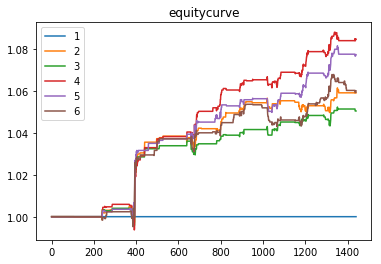

In [19]:
tester_ensemble.plot()

In [20]:
tester_ensemble.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
Model Order,,,,,,,,,,,,,
1,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1,1.000000,0.000000
2,0.112806,0.004230,-0.001113,0.001315,0.000196,-0.005783,0.017553,-0.008142,1.180854,9.373416,302,1.059213,0.278146
3,0.100453,0.003609,-0.001178,0.001408,0.000263,-0.005783,0.017553,-0.008378,1.194875,8.982423,192,1.050530,0.317708
4,0.112160,0.006061,-0.001071,0.001347,0.000357,-0.005783,0.017553,-0.012157,1.258102,13.510609,238,1.084860,0.394958
5,0.124873,0.005532,-0.001033,0.001397,0.000332,-0.005783,0.017553,-0.006465,1.352311,11.075093,233,1.077447,0.364807
6,0.128478,0.004295,-0.001101,0.001368,0.000179,-0.004113,0.017553,-0.010102,1.243065,8.357164,336,1.060128,0.264881
